# Goal of Analysis:

## 1. find the next city the tourists will most likely visit based on their last city choice

## 2. cluster cities into two groups: high intent and low intent

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

### Part 1: Load Data

In [2]:
def clean_json(d):
    """
    clean the json data, make the data easier to be processed
    """
    assert len(d['cities']) == 1
    d['cities'] = d['cities'][0]

    assert len(d['session_id']) == 1
    d['session_id'] = d['session_id'][0]

    assert len(d['unix_timestamp']) == 1
    d['timestamp'] = datetime.datetime.utcfromtimestamp(d['unix_timestamp'][0])
    del d['unix_timestamp']

    # -------- retrieve users
    user_dict = d['user']

    assert len(user_dict) == 1
    user_dict = user_dict[0]

    assert len(user_dict) == 1
    user_dict = user_dict[0]

    d['user_id'] = user_dict['user_id']
    d['user_country'] = user_dict['country']

    del d['user']
    return d

In [3]:
import json
import datetime

with open("city_search.json",'rt') as inf:
    sessions = json.load(inf)
    
for d in sessions:
    clean_json(d)

data = pd.DataFrame(sessions)
data = data.set_index('session_id')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20022 entries, X061RFWB06K9V to TVJS9Z6EZDPEA
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cities        20022 non-null  object        
 1   timestamp     20022 non-null  datetime64[ns]
 2   user_id       20022 non-null  int64         
 3   user_country  20022 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 782.1+ KB


In [5]:
data.head()

,cities,timestamp,user_id,user_country
session_id,,,,
X061RFWB06K9V,"New York NY, Newark NJ",2015-09-17 15:28:28,2024,UK
5AZ2X2A9BHH5U,"New York NY, Jersey City NJ, Philadelphia PA",2015-09-04 08:06:31,2853,DE
SHTB4IYAX4PX6,San Antonio TX,2015-08-29 10:18:10,10958,UK
JBRB8MZGTX3M4,Edmonton AB,2015-03-25 07:21:03,7693,IT
YJCMPURC2FL9C,"Phoenix AZ, Houston TX",2015-05-02 09:31:07,7506,UK


### Part 2: There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?

In [6]:
# check the value country
data['user_country'].value_counts().reset_index().rename(columns={'index': 'country', 'country': 'count'})

,country,user_country
0,US,3876
1,DE,3638
2,UK,3555
3,,2820
4,FR,2298
5,ES,1953
6,IT,1882


There is a missing value in country but we cannot see it from the table above, therefore I will try to use other information to see if I can guess the country

In [7]:
# extract search time information
data['time'] = pd.to_datetime(data['timestamp'], unit='s')
data['hour'] = data['time'].apply(lambda x: x.hour)

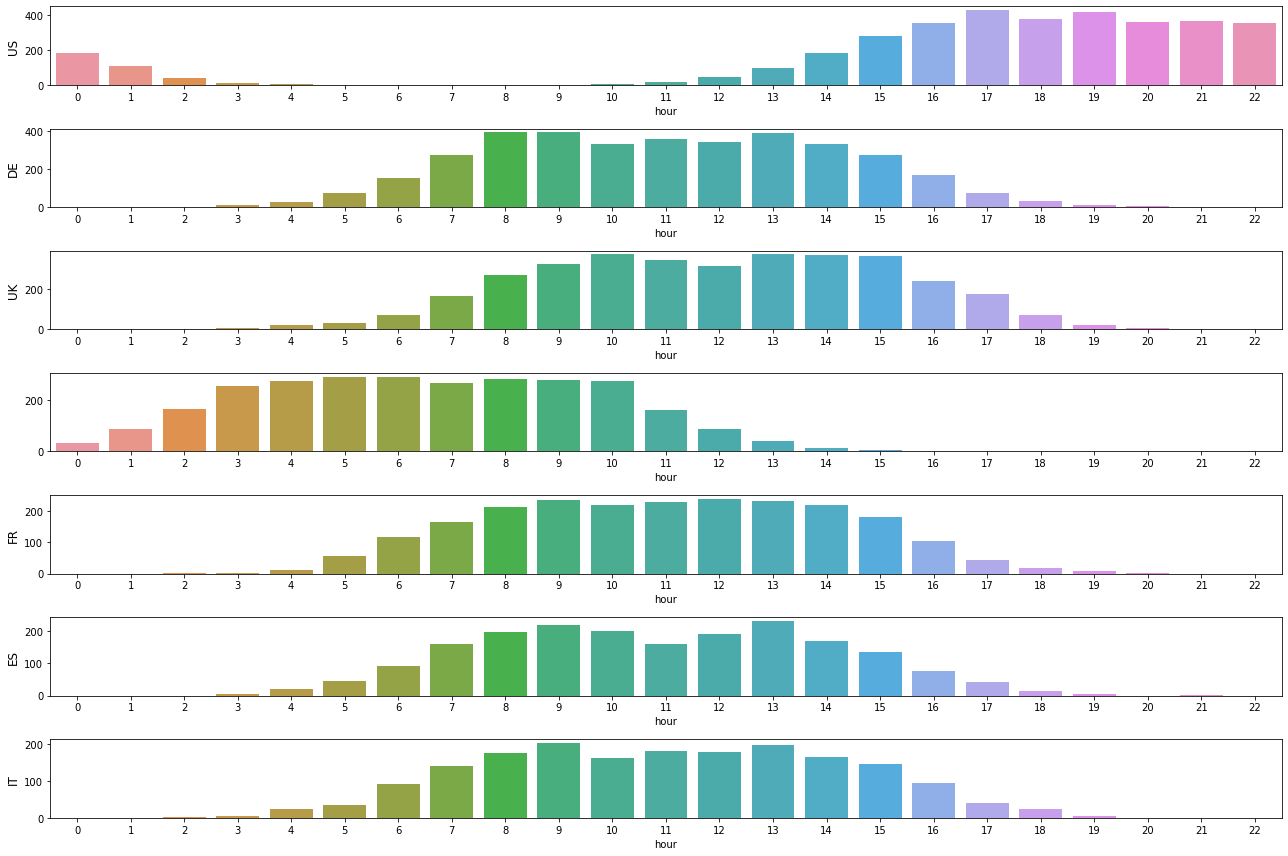

In [8]:
# visualization
country_list = ['US', 'DE', 'UK', '', 'FR', 'ES', 'IT']
order = list(range(0, 23))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data=data[data['user_country'] == country_list[i]], ax=ax[i], order=order)
    ax[i].set_ylabel(country_list[i], fontsize=12)
plt.tight_layout()
plt.show()

Based on above charts, we can see that, for the unknown country, their peak search time has around 12 hours difference with United States, and around 5 hours difference with Europe. Based on the geographic locations of each country, it seems that this missing country is in Asia. Possible countries include China, Japan, and South Korea.

### Part 3:For each city, find the most likely city to be also searched for within the same session.

I want to create a matrix that will display the city-city similarity

In [9]:
from collections import Counter

data['cities'] = data.cities.str.split(', ')
def count_cities(df):
    c = Counter(city for cities in df.cities for city in cities)
    return pd.Series(c)
searchcity_by_user = data.groupby("user_id").apply(count_cities).unstack(fill_value=0)

In [10]:
searchcity_by_user = searchcity_by_user.transpose()

In [11]:
searchcity_by_user.head()

user_id,4,5,9,10,11,13,15,17,18,20,...,10972,10973,10977,10979,10980,10981,10982,10988,10990,11000
Anaheim CA,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Arlington TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atlanta GA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Austin TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bakersfield CA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# make each row unit-norm, then dot-product is equivalent to cosine
from sklearn.preprocessing import normalize

searchcity_by_user_normed = normalize(searchcity_by_user,axis=1)

In [13]:
city_similarity = searchcity_by_user_normed.dot(searchcity_by_user_normed.T)
city_similarity = pd.DataFrame(city_similarity,
                               index = searchcity_by_user.index,
                               columns = searchcity_by_user.index)

In [14]:
city_similarity.head()

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
Anaheim CA,1.000000,0.033731,0.026082,0.037796,0.019139,0.038984,0.000000,0.047099,0.029180,0.077773,...,0.022195,0.118564,0.000000,0.018019,0.092873,0.037937,0.014494,0.026239,0.0,0.013199
Arlington TX,0.033731,1.000000,0.000000,0.243935,0.015064,0.036820,0.000000,0.037070,0.007655,0.040808,...,0.017469,0.058240,0.000000,0.113455,0.061675,0.039812,0.000000,0.020652,0.0,0.020777
Atlanta GA,0.026082,0.000000,1.000000,0.013801,0.000000,0.028470,0.494872,0.017198,0.017758,0.025817,...,0.020261,0.030704,0.051434,0.000000,0.037092,0.015392,0.000000,0.023953,0.0,0.000000
Austin TX,0.037796,0.243935,0.013801,1.000000,0.000000,0.045383,0.000000,0.039876,0.020587,0.062354,...,0.023489,0.132595,0.014907,0.019069,0.096751,0.049071,0.015339,0.013884,0.0,0.027937
Bakersfield CA,0.019139,0.015064,0.000000,0.000000,1.000000,0.010446,0.000000,0.037860,0.013031,0.012630,...,0.044603,0.038303,0.000000,0.048280,0.038883,0.022589,0.000000,0.000000,0.0,0.035366


In [15]:
### find top K most similar of each city

def most_similar(s,topk):
    # [0] must be itself
    similar_ones = s.sort_values(ascending=False)[1:topk+1].index.values
    return pd.Series(similar_ones,index = ["similar#{}".format(i) for i in range(1,topk+1)])

most_similar_cities = city_similarity.apply(most_similar,topk=1,axis=1)

In [16]:
# check the result

most_similar_cities.sample(20)

,similar#1
Jersey City NJ,Newark NJ
Columbus OH,Cincinnati OH
Victoria BC,Seattle WA
Buffalo NY,Saint Catharines-Niagara ON
Calgary AB,Seattle WA
Norfolk VA,Virginia Beach VA
Mesa AZ,Chandler AZ
Fort Worth TX,Arlington TX
Arlington TX,Fort Worth TX
San Francisco CA,Oakland CA


### Part 4: cluster similar cities

In [17]:
data["num_searched"] = data.cities.map(len)

In [18]:
def search_distance(cities,similar2dist):
    """
    input: 
        cities: a list of cities included in the search
        similar2dist: a function which maps similarity to distance
    return: 
        distance: distance among cities in the search
    """
    sumdist = 0
    total = len(cities)

    # if total=1, then distance =0
    for i1 in range(total-1):
        city1 = cities[i1]

        for i2 in range(i1+1,total):
            city2 = cities[i2]

            similarity = city_similarity.loc[city1,city2]
            dist = similar2dist(similarity)

            sumdist += dist

    # if there are n cities in the search, sum will be calculated 0.5*n*(n-1) times
    # then the distance biased too much to search which contains many cities
    # so I decide to divide 'n', then the distance is O(n) instead of O(n2)
    # which is more fair, but also takes account of "more city in the search, more likely to be irrelevant"
    return sumdist / total

In [19]:
distances = data.cities.map(lambda cities: search_distance(cities,lambda s: np.sqrt(1-s*s)))

<AxesSubplot:>

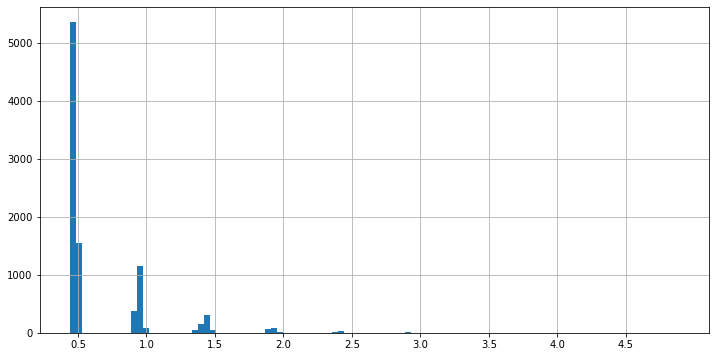

In [20]:
plt.xticks(np.arange(0,5,0.5))
# filter out distance=0, because a lot of search with one city will have distance=0

distances[distances>0].hist(bins=100, stacked=True, figsize=(12,6))

I decide to choose distance=0.9 as the cutoff between 'high intent search' and 'low intent search'. if the distance is higher than 0.9, then I classify such search as 'low intent'.

In [21]:
dist_cutoff = 0.9
print('percentage of low intent search: {:.2f}%'.format((distances>dist_cutoff).mean() * 100))

percentage of low intent search: 12.21%


In [22]:
low_intent_search = data.loc[distances>dist_cutoff,['num_searched','cities']]

In [23]:
low_intent_search

,num_searched,cities
session_id,,
5AZ2X2A9BHH5U,3,"[New York NY, Jersey City NJ, Philadelphia PA]"
7BQ7VDHTZYRPD,3,"[Vancouver BC, Victoria BC, Seattle WA]"
IGWYW7VQBR7BW,3,"[Phoenix AZ, Chandler AZ, Mesa AZ]"
EEBNPTA77L6YT,4,"[San Antonio TX, Corpus Christi TX, Arlington ..."
5HILT84J9UF4W,4,"[Calgary AB, Seattle WA, Victoria BC, Portland..."
...,...,...
KU2EVVKG0EK9L,3,"[San Diego CA, New York NY, Houston TX]"
H0ZSJHI32ERG9,3,"[Houston TX, Chicago IL, Los Angeles CA]"
CA656UDFEP1KP,3,"[Los Angeles CA, Anaheim CA, Riverside CA]"
